# Projeto 1 - Ciência dos Dados

Nome: Diogo dos Reis Duarte

Nome: Jorás Custodio Campos

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
!pip install emoji
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import emoji
from emoji import UNICODE_EMOJI
import functools
import operator
import re

from sklearn.model_selection import train_test_split

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Lava Boy 2.0\Desktop\Desktop\Insper\2-semestrePt2\cdados\CdadosProjeto1


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
import os

filename = 'PS5.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com a prova!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo PS5.xlsx, tudo certo para prosseguir com a prova!


In [4]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Classificação
0,"@bossupbaby_ if you still need a ps5, i got mi...",P
1,@ketan_patel07 @target same! i’m still mad the...,R
2,my brother got himself a ps5... consider me je...,R
3,silent hill’s keiichiro toyama is working with...,I
4,@awesomejon21 bruh 20 on the ps5 will make you...,P


In [5]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Classificação
0,waited 4 months for the ps5 controller chargin...,R
1,@mattswider thanks to you my ps5 finally came ...,I
2,all accessories up on playstation direct....co...,P
3,@mk2true you got any ps5 kicking about..,I
4,@romudeth i want sony to compete with bringing...,R


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

O produto a ser analisado será o novo console da Sony, o Playstation 5. Ao analisar os tweets, conseguimos encontrar 3 padrões, os quais avaliamos os nossos tweets. Estes foram (R) de relevante, que são tweets que trazem discussões e opiniões a cerca do produto, (P) de pouco relevante, que são os tweets que fazem propagandas do produto junto com outros itens adjacentes, como por exemplo acessórios (fones, headset, controles) ou jogos, ou tweets que se remetem a vendas a cerca do produto, e (I) de irrelevante, que são tweets que não se encaixam nos padrões mencionados, ou que simplesmente não fala do produto.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [6]:
def separate_emoji(text): #separa emojis dos outros caracteres
    return ''.join(' ' + char if char in UNICODE_EMOJI else char for char in text).strip() #caso seja um emoji, adiciona um espaco, caso nao seja, apenas retorna a letra.

In [7]:
chars = [",", "'", '"', ".", "!", "?", ";", ":", "[", "]","{", "}", "(", ")", "#", "/",  "\\", "https","+", "@", "*", "-"] 
word_count = dict()
total = 0 #total de palavras no banco de dados

train.Classificação = train.Classificação.apply(lambda x: x.upper())
for i, tweet in train.iterrows(): #iterando a base de dados
    piu = tweet.Treinamento #carregando apenas os tweets
    
    for c in chars: #iterando a listad e cacarteres p/ remover
        piu = piu.replace(c, " ") #trocando os caracteres por " "
        
    for word in separate_emoji(piu).split(): #splitando os tweets em palavras e emojis separadamente
        word_count[word] = word_count.get(word, {'I':0, 'P':0, 'R':0}) #garantindo que  a palavra existe no dicionario, caso nao exista ela eh criada
        word_count[word][tweet.Classificação] += 1 #incrementando o contador do valor correto
        total += 1
        
I = {word: word_count[word]['I'] for word in word_count if word_count[word]['I'] > 0} #I contem todas as palavras Irrelevantes, seu sum(I.values) == total de palavras Irrelevantes
P = {word: word_count[word]['P'] for word in word_count if word_count[word]['P'] > 0} #P contem todas as palavras Pouco relevantes, seu sum(P.values) == total de palavras Pouco relevantes
R = {word: word_count[word]['R'] for word in word_count if word_count[word]['R'] > 0} #R contem todas as palavras Relevantes, seu sum(R.values) == total de palavras Relevantes

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [8]:
# totalR = (sum(R.values())) #total de palavaras na categoria Relevante
# totalP = (sum(P.values())) #total de palavaras na categoria Pouco Relevante
# totalI = (sum(I.values())) #total de palavaras na categoria Irrelevante

#como ja era um dicionario previamente, nao tem a necessidade de usar o comando value.counts(True)
tabela_relativa_R = pd.Series(R)

tabela_relativa_P = pd.Series(P)

tabela_relativa_I = pd.Series(I)



totalR = tabela_relativa_R.size #total de palavaras na categoria Relevante
totalP = tabela_relativa_P.size #total de palavaras na categoria Pouco Relevante
totalI = tabela_relativa_I.size #total de palavaras na categoria Irrelevante


#Calculando o P(P), P(R) e P(I)
probR = totalR/total

probP = totalP/total

probI = totalI/total

l = [] #lista de classificacoes, mesma ordem da base test
for i, tweet in test.iterrows(): #iterando a base de dados
    
    #inicializamos como 1 para nao dar erro na multiplicacao
    probTweetR = 1  
    probTweetP = 1
    probTweetI = 1 
    
    piu = tweet.Teste #carregando apenas os tweets 
    
    for c in chars: #iterando a listad e cacarteres p/ remover
        piu = piu.replace(c, " ") #trocando os caracteres por " "
    
    #splitando os tweets em palavras e emojis separadamente e calculando a probalidade de cada palavra de ser cada categoria, fazendo a suavizacao de laplace
    for word in separate_emoji(piu).split(): 
        
        #Calculando o P(T|P), P(T|R) e P(T|I)
        #pega o erro de palavras que nao existem em uma das tabelas
        try: 
            probTweetR *= tabela_relativa_R[word]
        except:
            pass
        
        try: 
            probTweetP *= tabela_relativa_P[word]
        except:
            pass
        
        try: 
            probTweetI *= tabela_relativa_I[word]
        except:
            pass

    #calculando P(P|T), P(R|T), P(I|T)
    probTweetR = probTweetR * probR
    
    probTweetP = probTweetP * probP
    
    probTweetI = probTweetI * probI
    
    result = {"R":probTweetR,"P":probTweetP,"I": probTweetI} #dicionario para a comparacao dentro do MAX abaixo
    l.append(max(result, key = result.get)) #compara os valores de r, p, i, e adiciona correta a lista L 

test["Classificação_A"] = l #adiciona a coluna classificacao a test, como a ordem eh a mesma, podemos adicionar.

test.head(20)

D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in longlong_scalars


,Teste,Classificação,Classificação_A
0,waited 4 months for the ps5 controller chargin...,R,I
1,@mattswider thanks to you my ps5 finally came ...,I,I
2,all accessories up on playstation direct....co...,P,P
3,@mk2true you got any ps5 kicking about..,I,I
4,@romudeth i want sony to compete with bringing...,R,P
5,@littlemyuri @its_menieb @xboxgamepass @xbox o...,R,R
6,god of war 4 walkthrough last part secret endi...,P,P
7,@nsarmoredfrog awesome! this should to happen ...,R,I
8,"@yukomama711 split the money if ya’ll win, if ...",P,I
9,"#demonssouls #ps5 demon's souls ps5 #ps5share,...",P,P


In [9]:
l = [] #lista de classificacoes, mesma ordem da base test

for i, tweet in train.iterrows(): #iterando a base de dados
    
    #inicializamos como 1 para nao dar erro na multiplicacao
    probTweetR = 1  
    probTweetP = 1
    probTweetI = 1 
    
    piu = tweet.Treinamento #carregando apenas os tweets 
    
    for c in chars: #iterando a lista de caracrteres p/ remover
        piu = piu.replace(c, " ") #trocando os caracteres por " "
    
    #splitando os tweets em palavras e emojis separadamente e calculando a probalidade de cada palavra de ser cada categoria, fazendo a suavizacao de laplace
    for word in separate_emoji(piu).split(): 
        
        #Calculando o P(T|P), P(T|R) e P(T|I)
        #pega o erro de palavras que nao existem em uma das tabelas
        try: 
            probTweetR *= tabela_relativa_R[word]
        except:
            pass
        
        try: 
            probTweetP *= tabela_relativa_P[word]
        except:
            pass
        
        try: 
            probTweetI *= tabela_relativa_I[word]
        except:
            pass

    #calculando P(P|T), P(R|T), P(I|T)
    probTweetR = probTweetR * probR
    
    probTweetP = probTweetP * probP
    
    probTweetI = probTweetI * probI
    
    result = {"R":probTweetR,"P":probTweetP,"I": probTweetI} #dicionario para a comparacao dentro do MAX abaixo
    l.append(max(result, key = result.get)) #compara os valores de r, p, i, e adiciona correta a lista L 

train["Classificação_A"] = l #adiciona a coluna classificacao a test, como a ordem eh a mesma, podemos adicionar.

train.head(20)

D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in longlong_scalars


,Treinamento,Classificação,Classificação_A
0,"@bossupbaby_ if you still need a ps5, i got mi...",P,P
1,@ketan_patel07 @target same! i’m still mad the...,R,R
2,my brother got himself a ps5... consider me je...,R,I
3,silent hill’s keiichiro toyama is working with...,I,I
4,@awesomejon21 bruh 20 on the ps5 will make you...,P,I
5,.@officialteehub offers the best price on that...,I,R
6,@askplaystation the new ps5 that i gave my son...,R,R
7,@moonzugn been on twitter for years and all st...,P,I
8,"@thesitesupply you got me a ps5, now i need a...",P,P
9,@jacktheflippa probably wants a ps5 first,P,I


In [10]:
print(test.Classificação.value_counts(normalize=True))
print(train.Classificação.apply(lambda x: x.upper()).value_counts(normalize=True))

P    0.396
I    0.308
R    0.296
Name: Classificação, dtype: float64
I    0.390
P    0.356
R    0.254
Name: Classificação, dtype: float64


In [11]:
print('teste')
(pd.crosstab(test.Classificação,test.Classificação_A, normalize = 'index')*100).round(5)

teste


Classificação_A,I,P,R
Classificação,,,
I,59.74026,25.97403,14.28571
P,44.44444,33.33333,22.22222
R,40.54054,29.72973,29.72973


In [12]:
print('teste - quantitativo')
pd.crosstab(test.Classificação, test.Classificação_A)

teste - quantitativo


Classificação_A,I,P,R
Classificação,,,
I,46,20,11
P,44,33,22
R,30,22,22


In [13]:
print('treinamento')
(pd.crosstab(train.Classificação,train.Classificação_A, normalize = 'index')*100).round(5)

treinamento


Classificação_A,I,P,R
Classificação,,,
I,64.10256,23.58974,12.30769
P,25.28090,58.98876,15.73034
R,35.43307,22.83465,41.73228


In [14]:
print('treinamento - quantitativo')
pd.crosstab(train.Classificação, train.Classificação_A)

treinamento - quantitativo


Classificação_A,I,P,R
Classificação,,,
I,125,46,24
P,45,105,28
R,45,29,53


___
## Concluindo

        Para concluir e finalizar o projeto, vamos analisar o nosso sistema de seleção de dados. Em relação ao nosso classificador, nós vemos que comparando a nossa classificação manual com o classificador, na base de dados de treino, 66,15% dos tweets irrelevantes se manteram na mesma posição, assim como 54,49% dos pouco relevantes e 38,58% dos relevantes. Enquanto isso na base de teste, 55,84% dos tweets irrelevantes se manteram na mesma posição, assim como 36,36% dos pouco relevantes e 35,13% dos relevantes. Esta discrepância pode ser explicada pelo relaxamento em nosso critério durante a classificação manual, e pelo fato de ser uma base de dados sendo classificada por 2 pessoas diferentes, em que cada uma pode possuir uma interpretação levemente diferente.

## Por que não posso usar o próprio classificador para gerar mais amostras de treinamento

        Não se pode usar o classificador para gerar mais amostras de treinamento, pois estas são feitas por seres humanos que tem uma interpretação do que significa ser relevante, irrelevante ou pouco relevante, enquanto o classificador apenas considera a frequência da palavra no tweet e no banco de dados. Assim qualquer variação na rigorosidade cria um efeito exacerbado no resultado do classificador, e ao usá-lo para gerar novos treinamentos, os próprios erros do classificador serão considerados corretos, fazendo com que ao longo do tempo ele irá desviar cada vez mais do padrão original, tendendo para um resultado completamente fora do escopo incial.

## Propondo diferentes cenarios para utiliza o classificador Naive-Bayes:

        Para melhorar o sistema de blacklist de sites para as redes de escolas, podemos adotar este método para banir sites de acordo com as palavras pesquisadas pelos alunos na internet.

        Um cenário em que uma pessoa é suspeita de um crime, e há poucas provas e evidências, que mostram sua inocência ou culpa. Então, utilizamos o classificador para pegar as palavras mais usadas da pessoa em sites de pesquisa na internet, e passamos elas por um classificador treinado por palavras relevantes ao crime, para ver se a pessoa possui alguma pesquisa suspeita e que crie uma evidência contra ela

## Sugestões e explicações de melhorias reais para o nosso classificador

        Como nossas mensagens são em inglês, a dupla negação seria errado gramaticalmente, não sendo necessária um tratamento para esta questão. Em questão ao tratamento de mensagens sarcásticas,seria muito difícil identificar estas, uma vez que nas redes sociais não há intonação de fala, um dos principais recursos para identificar sarcasmos.
Uma melhoria direta seria ultilizar um algoritmo que usa a frequência e quantidade de emojis nos tweets para identificar sarcasmo, um exemplo e pesquisa direta seria: https://www.media.mit.edu/articles/an-algorithm-trained-on-emoji-knows-when-you-re-being-sarcastic-on-twitter/



        Em relação ao plano de expansão de nosso projeto, poderíamos tentar ver se conseguiriamos tratar as mensagens sarcásticas, visto que elas podem ter um padrão de palavras como “lol”, “kekw” ou simplesmente um “haha”. Mas tendo observado que estes termos podem estar em mensagens que contém conteúdo não sarcástico, um estudo sobre as mensagens seria importante para evitar este erro, e aumentar a precisão.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [15]:
split = pd.read_excel(filename, sheet_name = '6')

In [16]:
#construindo a funcao

def classifier(X_train, X_test, y_train, y_test):
    
    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    
    def separate_emoji(text): #separa emojis dos outros caracteres
        return ''.join(' ' + char if char in UNICODE_EMOJI else char for char in text).strip() #caso seja um emoji, adiciona um espaco, caso nao seja, apenas retorna a letra.

    chars = [",", "'", '"', ".", "!", "?", ";", ":", "[", "]","{", "}", "(", ")", "#", "/",  "\\", "https","+", "@", "*", "-"] 
    word_count = dict()
    total = 0 #total de palavras no banco de dados

    

    map(str.upper, y_train) #deixando tudo upper case

      
    for c in chars: #iterando a listad e cacarteres p/ remover
        y_train =  [x if x != c else ' ' for x in y_train]

    tweet_counter = 0 #contador para o word_count[word][X_train[tweet_counter]], conta o tweet que estamos na iteracao atual acessa a classificaca adequeada 
    
    for piu in y_train: #esplitando em palavras e tweets separadaros 
        split_emoji = emoji.get_emoji_regexp().split(piu)
        split_whitespace = [substr.split() for substr in split_emoji]
        split = functools.reduce(operator.concat, split_whitespace)
        tweet_counter += 1
        for word in split:
            word_count[word] = word_count.get(word, {'I':0, 'P':0, 'R':0}) #garantindo que  a palavra existe no dicionario, caso nao exista ela eh criada
            word_count[word][X_train[tweet_counter - 1]] += 1 #incrementando o contador do valor correto #X_train
            total += 1
        

    I = {word: word_count[word]['I'] for word in word_count if word_count[word]['I'] > 0} #I contem todas as palavras Irrelevantes, seu sum(I.values) == total de palavras Irrelevantes
    P = {word: word_count[word]['P'] for word in word_count if word_count[word]['P'] > 0} #P contem todas as palavras Pouco relevantes, seu sum(P.values) == total de palavras Pouco relevantes
    R = {word: word_count[word]['R'] for word in word_count if word_count[word]['R'] > 0} #R contem todas as palavras Relevantes, seu sum(R.values) == total de palavras Relevantes


    tabela_relativa_R = pd.Series(R)

    tabela_relativa_P = pd.Series(P)

    tabela_relativa_I = pd.Series(I)



    totalR = tabela_relativa_R.size #total de palavaras na categoria Relevante
    totalP = tabela_relativa_P.size #total de palavaras na categoria Pouco Relevante
    totalI = tabela_relativa_I.size #total de palavaras na categoria Irrelevante


    #Calculando o P(P), P(R) e P(I)
    probR = totalR/total

    probP = totalP/total

    probI = totalI/total
    
    #daqui em diante usar o X_test e y_test
    l = [] #lista de classificacoes, mesma ordem da base test
    for tweet in y_test: #iterando a base de dados

        #inicializamos como 1 para nao dar erro na multiplicacao
        probTweetR = 1  
        probTweetP = 1
        probTweetI = 1 


        for c in chars: #iterando a listad e cacarteres p/ remover
            y_test = tweet.replace(c, " ") #trocando os caracteres por " "

        #splitando os tweets em palavras e emojis separadamente e calculando a probalidade de cada palavra de ser cada categoria, fazendo a suavizacao de laplace
        for word in separate_emoji(tweet).split(): 

            #Calculando o P(T|P), P(T|R) e P(T|I)
            #pega o erro de palavras que nao existem em uma das tabelas
            try: 
                probTweetR *= tabela_relativa_R[word]
            except:
                pass

            try: 
                probTweetP *= tabela_relativa_P[word]
            except:
                pass

            try: 
                probTweetI *= tabela_relativa_I[word]
            except:
                pass

        #calculando P(P|T), P(R|T), P(I|T)
        probTweetR = probTweetR * probR

        probTweetP = probTweetP * probP

        probTweetI = probTweetI * probI

        result = {"R":probTweetR,"P":probTweetP,"I": probTweetI} #dicionario para a comparacao dentro do MAX abaixo
        l.append(max(result, key = result.get)) #compara os valores de r, p, i, e adiciona correta a lista L 
    
    X_test = pd.DataFrame.from_dict(data = X_test)
    X_test["Classificador"] = l #adiciona a coluna classificacao a test, como a ordem eh a mesma, podemos adicionar.

    #print(X_test)
    return X_test

In [17]:
# Definindo o grupo de variáveis independentes
X = split["Classificação"]

# Definindo o grupo de variáveis dependentes
y = split['tweets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 250, train_size = 500, random_state = i)
results = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 250, train_size = 500, random_state = i)

    plsWork =  classifier(X_train, X_test, y_train, y_test)
    
    tab = (pd.crosstab(plsWork[0], plsWork.Classificador , normalize = True)*100).round(5)
    results.append(tab.I.I + tab.P.P + tab.R.R)

D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in longlong_scalars
D:\anaconda-Python\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in longlong_scalars


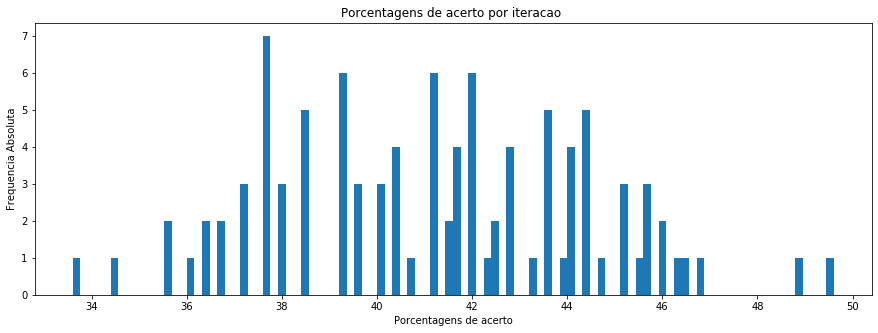

In [18]:
results = pd.DataFrame(data = results)

results = results.T


plt.figure(figsize=(15, 5))
plt.hist(results, bins = 100)   #np.arange(0, 100, 1))
plt.title('Porcentagens de acerto por iteracao ')
plt.xlabel('Porcentagens de acerto')
plt.ylabel('Frequencia Absoluta')
plt.show()

## Discutindo o histograma

    Ao construir um Classificador e considerar apenas uma divisão dos dados, estamos desconsiderando as outras possibilidades que dariam resultados diferentes da escolhida. Isto é ruim para o Classificador, uma vez que ao escolher um test train split que infla a taxa de sucesso, está mentindo sobre a real eficácia do Classificador. Podemos ver isso no histograma acima, em que o Classificador poderia ter a porcentagem de acerto de 49%, porém ela é a uma das menos frequentes, o que não representaria a verdadeira eficácia do Classificador. Seria adequado relatar que o Classificador tivesse algo em torno de 38-42% de porcentagem de acerto, uma vez que é uma parte do histograma que apresenta mais frequência em relação as outras porcentegens de acerto.

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**